<a href="https://www.kaggle.com/code/abd0kamel/mutemotion-wlasl-translation-model?scriptVersionId=154747750" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Introduction**

<h3> This notebook aims to use MediaPipe landmarks detection as the starting point
    
<h3> for building an American Sign Language Translation Model
            
**<h3> Sections:**
* [Importing Libraries](#Importing)
* [Data Preparation](#Preparation)
* [MediaPipe Implementation](#MediaPipe)
* [Visualizing landmarks](#Visualizing)
* [Data Encoding](#Encoding)
* [Data Loading](#Loading)
* [Data Augmentation](#Augmentation)
* [Data Preprocessing](#Preprocessing)
* [Models](#Models)
    
<h4> If you found this notebook helpful, an upvote would be appreciated!

---

<div id="Importing">
    
# **Importing Libraries** 

In [1]:
!pip install -q mediapipe==0.10.7

In [2]:
import os
import gc
import cv2
import json
import time
import shutil
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---

<div id="Preparation">
    
# **Data Preparation**
**<h2>(Done Once)**

<h3> We first load the data

In [ ]:
with open('/kaggle/input/wlasl-processed/WLASL_v0.3.json', 'r') as json_file:
    all_data = json.load(json_file)

<h3> Then we extract the needed information from the data
<h4>    
    
* gloss : the word being expressed
    
* video_path : the path to the video in the datasets
    
* frame_start : the frame number where the word starts
    
* frame_end : the frame number where each word ends
   
* split : the type of data when modeling (train, val, test)

In [ ]:
video_dir = '/kaggle/input/wlasl-processed/videos'
backup_dir = '/kaggle/input/wlasl2000-resized/wlasl-complete/videos'
data = [] # formatted data

for i in tqdm(range(len(all_data)), ncols=100):
    gloss = all_data[i]['gloss']
    instances = all_data[i]['instances']
    for instance in instances:
        video_id = instance['video_id']
        if os.path.exists(os.path.join(video_dir, f'{video_id}.mp4')):
            video_path = os.path.join(video_dir, f'{video_id}.mp4')
        elif os.path.exists(os.path.join(backup_dir, f'{video_id}.mp4')):
            video_path = os.path.join(backup_dir, f'{video_id}.mp4')
        else:
            continue
            
        frame_start = instance['frame_start']
        frame_end = instance['frame_end']
        split = instance['split']
        data.append({
            'gloss': gloss,
            'video_path': video_path,
            'frame_start': frame_start,
            'frame_end': frame_end,
            'split': split
        })

In [ ]:
len(data)

<h3> We then save the organized dictionary for future uses

In [ ]:
with open('/kaggle/working/WLASL_parsed_data.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)
    
FileLink(r'WLASL_parsed_data.json')

---

<div id="MediaPipe">

# **MediaPipe Implementation**
**<h2>(Not important when training)**

<h3> We first choose the landmarks
<h4>    
    
* Hands : we'll keep all **42** of them, as they are the most important part.
    
* Pose : **6** landmarks for the upper body excluding the face, as we have dedicated process for it.
    
* Face : out of the **478** landmarks, we'll choose **132**, focusing on the lips, eyes, eyebrows, and the outline of the face.
    
* This brings the total number of landmarks to **180**, each with coordinates (x, y, z).   

In [3]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

<h3>Extracting landmarks from a frame

In [4]:
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)

def get_frame_landmarks(frame):
    
    all_landmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM, 3))
    
    def get_hands(frame):
        results_hands = hands.process(frame)
        if results_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                if results_hands.multi_handedness[i].classification[0].index == 0: 
                    all_landmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
                else:
                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left

    def get_pose(frame):
        results_pose = pose.process(frame)
        if results_pose.pose_landmarks:
            all_landmarks[HAND_NUM * 2:HAND_NUM * 2 + POSE_NUM, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
        
    def get_face(frame):
        results_face = face_mesh.process(frame)
        if results_face.multi_face_landmarks:
            all_landmarks[HAND_NUM * 2 + POSE_NUM:, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]
        
    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)
        executor.submit(get_pose, frame)
        executor.submit(get_face, frame)

    return all_landmarks

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<h3>Extracting landmarks from a video

In [5]:
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    
    # if the starting is 0
    if start_frame <= 1:
        start_frame = 1
        
    # if the video is precropped
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    # if the final frame was not given (-1)    
    if end_frame < 0: 
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1
    
    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_landmarks = get_frame_landmarks(frame)
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1

    cap.release()
    hands.reset()
    pose.reset()
    face_mesh.reset()
    return all_frame_landmarks

<h3>Drawing landmarks on a video

In [6]:
def draw_landmarks(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    if start_frame <= 1:
        start_frame = 1
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_index = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index >= start_frame and frame_index <= end_frame:
            frame_landmarks = video_landmarks[frame_index - start_frame]
            landmarks = [(int(x * width), int(y * height)) for x, y, _ in frame_landmarks]
            for x, y in landmarks:
                cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            out.write(frame)
        else:
            # out.write(frame) # Enable if you want the full video
            pass
        frame_index += 1

    cap.release()
    out.release()

---

<div id="Visualizing">

# **Visualizing landmarks**
**<h2>(Not important when training)**

<h3>Test on a frame

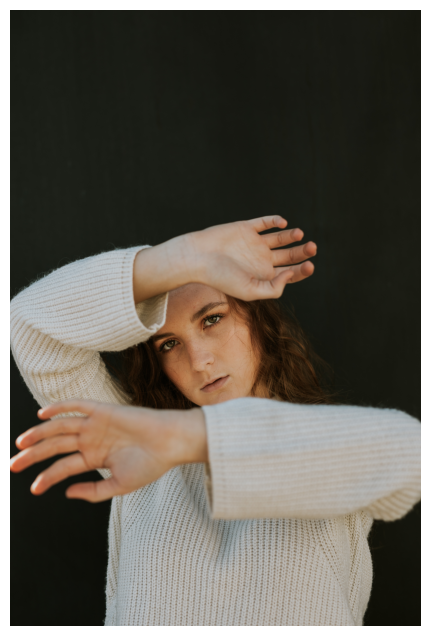

In [7]:
import requests
from PIL import Image
from io import BytesIO

image_url = 'https://images.unsplash.com/photo-1515294898968-a408405d7674'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

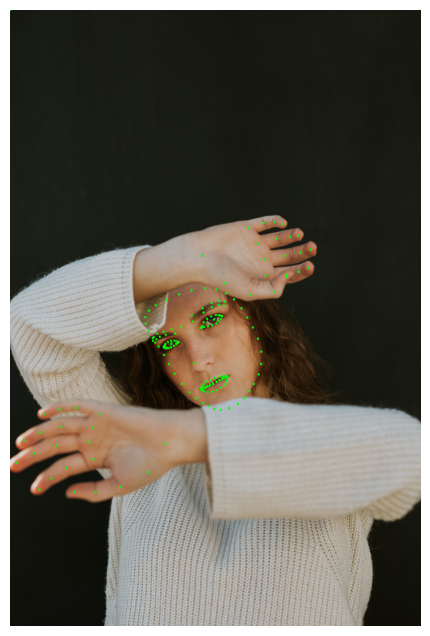

In [8]:
height, width, _ = img.shape

frame_landmarks = get_frame_landmarks(img[:,:,::-1])
for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

<h3> Test on video

In [9]:
with open('/kaggle/input/mutemotion-output/WLASL_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)
    
test = data[40]
video_landmarks = get_video_landmarks(test['video_path'],test['frame_start'],test['frame_end'])

output_path = '/kaggle/working/landmarks_test.mp4'
draw_landmarks(test['video_path'], output_path, video_landmarks, test['frame_start'],test['frame_end'])

In [ ]:
# os.remove('/kaggle/working/landmarks_test.mp4')

---

<div id="Encoding">
    
# **Data Encoding**
**<h2>(Done Once)**

In [ ]:
npy_dir = '/kaggle/working/landmarks'
os.makedirs(npy_dir, exist_ok=True)

In [ ]:
try:
    for i in tqdm(range(len(data)), ncols=100):
        npy_path = os.path.join(npy_dir, f'{i}.npy')
        if os.path.exists(npy_path): continue
        video_path = data[i]['video_path']
        start = data[i]['frame_start']
        end = data[i]['frame_end']
        
        try:
            video_landmarks = get_video_landmarks(video_path, start, end)
            np.save(npy_path, video_landmarks)
            
        except Exception as e:
            print(f"\nError encoding {video_path}\n{e}")
            continue   
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

In [ ]:
landmarks_dict = {}

for filename in os.listdir(npy_dir):
    if filename.endswith('.npy'):
        key = filename.split('.')[0]
        landmarks = np.load(os.path.join(npy_dir, filename), allow_pickle=True)
        landmarks_dict[key] = landmarks

np.savez_compressed('/kaggle/working/landmarks_V2.npz', **landmarks_dict)

FileLink(r'landmarks_V2.npz')

In [8]:
# shutil.rmtree(npy_dir)
# os.remove('/kaggle/working/landmarks_V2.npz')

---

<div id="Loading">
    
# **Data Loading**

In [10]:
landmarks_dict = np.load('/kaggle/input/mutemotion-output/landmarks_V3.npz', allow_pickle=True)

In [11]:
with open('/kaggle/input/mutemotion-output/WLASL_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)

<h3> Filter Landmarks (Only for V3)

In [12]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

In [13]:
landmarks = (
    [x for x in filtered_hand] +
    [x + HAND_NUM for x in filtered_hand] +
    [x + HAND_NUM * 2 for x in filtered_pose] +
    [x + HAND_NUM * 2 + POSE_NUM for x in filtered_face]
)

print(landmarks)
print(f'\nTotal Number: {len(landmarks)}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 53, 54, 55, 56, 57, 58, 48, 52, 55, 56, 58, 61, 62, 65, 69, 81, 85, 87, 88, 94, 100, 101, 102, 103, 106, 109, 111, 113, 114, 115, 118, 126, 128, 129, 130, 132, 135, 136, 139, 141, 143, 151, 153, 155, 157, 175, 180, 181, 184, 192, 193, 194, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 220, 221, 224, 226, 229, 233, 239, 282, 294, 297, 299, 311, 315, 317, 318, 324, 330, 331, 332, 333, 336, 339, 341, 343, 344, 345, 348, 356, 358, 359, 360, 362, 365, 366, 369, 371, 372, 380, 382, 384, 386, 404, 409, 410, 413, 421, 422, 423, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437, 438, 445, 446, 448, 450, 453, 457, 463, 502, 514, 516, 521]

Total Number: 180


<h3> Filter Data Source

In [14]:
# Only from the wlasl-processed dataset
keys = [k for k in landmarks_dict.keys() if 'wlasl-processed' in data[int(k)]['video_path']]

# Only from the wlasl2000-resized dataset
# keys = [k for k in landmarks_dict.keys() if 'wlasl2000-resized' in data[int(k)]['video_path']]

<h3> Loading Function

In [15]:
def load_data(split, labels=None, max_labels=None, max_samples=None, landmarks=None, keys=None):
    
    if landmarks is None:
        landmarks = list(range(landmarks_dict['0'].shape[1]))
    
    if keys is None:
        keys = [k for k in landmarks_dict.keys()]
    
    if labels is not None:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split and data[int(k)]['gloss'] in labels]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split and data[int(k)]['gloss'] in labels]
    
    elif max_samples is not None:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split][:max_samples]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split][:max_samples]
    
    elif max_labels is not None:
        label_counts = {}
        for k in keys:
            label = data[int(k)]['gloss']
            label_counts[label] = label_counts.get(label, 0) + 1
        
        top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:max_labels]
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]
        
    else:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split]
    
    return X, Y

In [16]:
X_train, Y_train = load_data('train', max_labels=200, landmarks=landmarks, keys=keys)
X_val, Y_val = load_data('val', max_labels=200, landmarks=landmarks, keys=keys)
X_test, Y_test = load_data('test', max_labels=200, landmarks=landmarks, keys=keys)

In [17]:
len(X_train), len(X_val), len(X_test)

(1432, 344, 248)

In [18]:
X_train[0].shape

(46, 180, 3)

In [21]:
len(np.unique(Y_train)), len(np.unique(Y_val)), len(np.unique(Y_test))

(200, 191, 171)

In [22]:
np.all(np.in1d(np.unique(Y_val), np.unique(Y_train))),\
np.all(np.in1d(np.unique(Y_test), np.unique(Y_train)))

(True, True)

In [23]:
# free space
del landmarks_dict, data
gc.collect()

275

---

<div id="Augmentation">
    
# **Data Augmentation**

<h3> Rotation Augmentations

In [24]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

<h3> Other Augmentations

In [25]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))

    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

def speedup(data):
    return data[::2]

<h3> Apply Augmentations

In [26]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1
    
    if counter == 0:
        data = apply_augmentations(data)

    return data

In [27]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()
    
    if num == None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [28]:
X_train, Y_train = augment(X_train, Y_train, num=1)

100%|███████████████████████████████████████████████████████████| 1432/1432 [00:14<00:00, 97.42it/s]


In [29]:
len(X_train), len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0])

(2864, 46, 180, 3)

In [30]:
# free space
gc.collect()

0

<h3> Data Permutation

In [31]:
permutation_train = list(range(len(Y_train)))
np.random.shuffle(permutation_train)
X_train = [X_train[i] for i in permutation_train]
Y_train = [Y_train[i] for i in permutation_train]

permutation_val = list(range(len(Y_val)))
np.random.shuffle(permutation_val)
X_val = [X_val[i] for i in permutation_val]
Y_val = [Y_val[i] for i in permutation_val]

permutation_test = list(range(len(Y_test)))
np.random.shuffle(permutation_test)
X_test = [X_test[i] for i in permutation_test]
Y_test = [Y_test[i] for i in permutation_test]

<h3> Test Augmentation (Not necessary when training)

In [32]:
frame_landmarks = np.expand_dims(frame_landmarks, axis=0)

In [33]:
frame_landmarks.shape

(1, 180, 3)

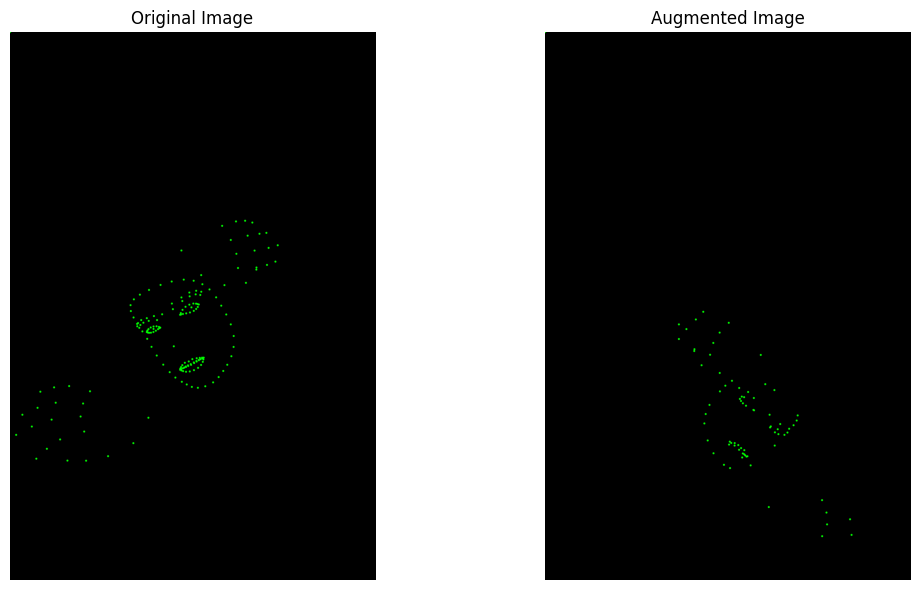

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

for landmark in frame_landmarks[0]:
    x = int(landmark[0] * img.shape[1])
    y = int(landmark[1] * img.shape[0])
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)
    
axs[0].set_title('Original Image')
axs[0].imshow(img[:, :, ::-1])
axs[0].axis('off')

augmented_landmarks = apply_augmentations(frame_landmarks.copy())
img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

for landmark in augmented_landmarks[0]:
    x = int(landmark[0] * img.shape[1])
    y = int(landmark[1] * img.shape[0])
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

axs[1].set_title('Augmented Image')
axs[1].imshow(img[:, :, ::-1])
axs[1].axis('off')

plt.tight_layout()
plt.show()

---

<div id="Preprocessing">
    
# **Data Preprocessing**

<h3>
    
**Method 1:** Sequencing

In [35]:
def sequences(X, Y, length=30, step=1, pad=0):
    X_sequences = []
    Y_sequences = []

    for inputs, label in zip(X, Y):
        num = inputs.shape[0]

        if num < length:
            padding = length - num
            inputs = np.pad(
            inputs, ((0, padding), (0, 0), (0, 0)),
            mode='constant', constant_values=pad
            )
            num = length

        for start in range(0, num - length + 1, step):
            end = start + length
            sequence = inputs[start:end]
            X_sequences.append(sequence)
            Y_sequences.append(label)

    X_sequences = np.array(X_sequences)
    Y_sequences = np.array(Y_sequences)
    return X_sequences, Y_sequences

In [36]:
X_train, Y_train = sequences(X_train, Y_train, length=60, step=20, pad=-100)
X_val, Y_val = sequences(X_val, Y_val, length=60, step=20, pad=-100)
X_test, Y_test = sequences(X_test, Y_test, length=60, step=20, pad=-100)

In [37]:
X_train.shape, X_val.shape, X_test.shape

((3788, 60, 180, 3), (461, 60, 180, 3), (370, 60, 180, 3))

<h3>
    
**Method 2:** Padding

In [42]:
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            X_padded.append(x[:length]) #truncate
        else:
            pad_length = length - len(x)
            X_padded.append(np.pad(
                x, ((0, pad_length), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))
            
    X_padded = np.array(X_padded)
    Y = np.array(Y)
    return X_padded, Y

In [43]:
X_train, Y_train = padding(X_train, Y_train, length=200, pad=-100)
X_val, Y_val = padding(X_val, Y_val, length=200, pad=-100)
X_test, Y_test = padding(X_test, Y_test, length=200, pad=-100)

In [45]:
X_train.shape, X_val.shape, X_test.shape

((10330, 200, 180, 3), (1332, 200, 180, 3), (948, 200, 180, 3))

---
<h3> Encoding the labels

In [38]:
label_encoder = LabelEncoder()

Y_train = label_encoder.fit_transform(Y_train)
Y_val = label_encoder.fit_transform(Y_val)
Y_test = label_encoder.fit_transform(Y_test)

In [39]:
Y_train

array([ 10, 105,  70, ..., 117, 109, 180])

In [40]:
# free space
gc.collect()

0

---

<div id="Models">
    
# **Models**

<h2>Hady's Model

<h2>Kamel's Model

In [41]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=-100, input_shape=(60, 180, 3)),
    tf.keras.layers.Reshape((60, 180 * 3)),

    tf.keras.layers.Conv1D(64, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(3, strides=1, padding='valid', depth_multiplier=1, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(64, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(5, strides=2, padding='valid', depth_multiplier=4, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPool1D(2, 2),

    tf.keras.layers.Conv1D(256, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(3, strides=1, padding='valid', depth_multiplier=1, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(256, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(5, strides=2, padding='valid', depth_multiplier=4, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(250)
])

In [44]:
checkpoint_filepath = '/kaggle/working/Kamel_Checkpoints/'
os.makedirs(checkpoint_filepath, exist_ok=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    metrics=['accuracy']
)

In [45]:
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=1000,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/1000
30/30 [==============================] - 19s 63ms/step - loss: 7.4517 - accuracy: 0.0095 - val_loss: 7.2650 - val_accuracy: 0.0000e+00
Epoch 2/1000
30/30 [==============================] - 1s 24ms/step - loss: 6.8734 - accuracy: 0.0195 - val_loss: 7.0872 - val_accuracy: 0.0000e+00
Epoch 3/1000
30/30 [==============================] - 1s 26ms/step - loss: 6.1887 - accuracy: 0.0269 - val_loss: 6.0779 - val_accuracy: 0.0065
Epoch 4/1000
30/30 [==============================] - 1s 23ms/step - loss: 6.0279 - accuracy: 0.0341 - val_loss: 5.6668 - val_accuracy: 0.0022
Epoch 5/1000
30/30 [==============================] - 1s 23ms/step - loss: 5.3184 - accuracy: 0.0494 - val_loss: 5.6641 - val_accuracy: 0.0022
Epoch 6/1000
30/30 [==============================] - 1s 23ms/step - loss: 5.0824 - accuracy: 0.0620 - val_loss: 5.6551 - val_accuracy: 0.0022
Epoch 7/1000
30/30 [==============================] - 1s 23ms/step - loss: 4.8401 - accuracy: 0.0686 - val_loss: 5.7753 - val_accurac

In [46]:
# epoch = 90
# model.load_weights(f'/kaggle/working/Kamel_Checkpoints/model_{epoch}.h5')
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

12/12 [==============================] - 0s 15ms/step - loss: 11.6349 - accuracy: 0.0054


In [43]:
import shutil
shutil.rmtree('/kaggle/working/Kamel_Checkpoints')

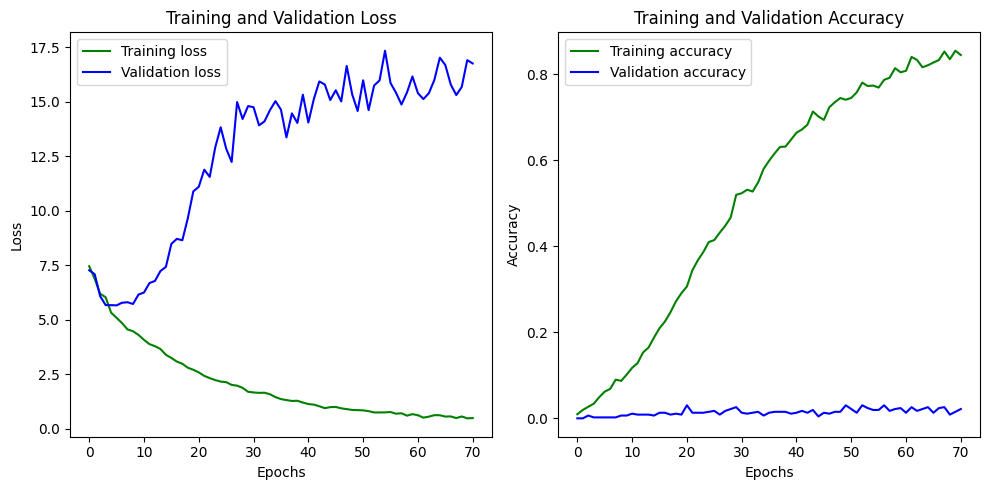

In [47]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

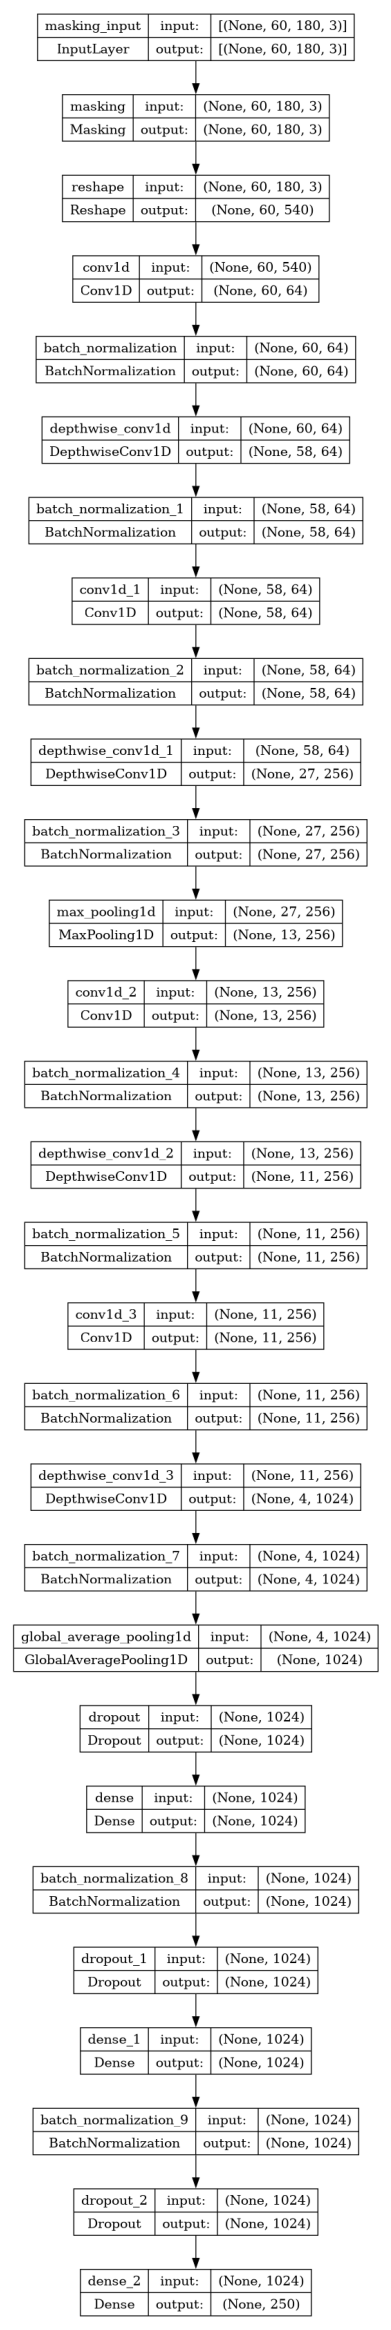

In [48]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_plot.png')
plt.figure(figsize=(40, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

In [49]:
name = '12-12'
model_filepath = '/kaggle/working/Kamel_Models'
os.makedirs(model_filepath, exist_ok=True)

model.save(model_filepath + f'/{name}')
model.save(model_filepath + f'/{name}.h5')

converter = tf.lite.TFLiteConverter.from_saved_model(model_filepath + f'/{name}')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
with open(model_filepath + f'/{name}.tflite', 'wb') as f:
    f.write(tflite_model)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h2>Nour's Model